# PyTorch workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* [Groud truth notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb)
* [Book version of notebook](https://www.learnpytorch.io/01_pytorch_workflow/)

In [27]:
import torch
from torch import nn  # nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.2.2'

# 1. Data (preparing and loading)

Data can ve almost anything... in ML
* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

ML is a game of 2 parts:
1. Get data into numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=-1)
y = weight * X + bias

X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [3]:
len(X), len(y)

(50, 50)

## Splitting data into training and tests sets

In [4]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualizing the data

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label="Predictions")

    plt.legend(prop={'size': 14})
    plt.show()

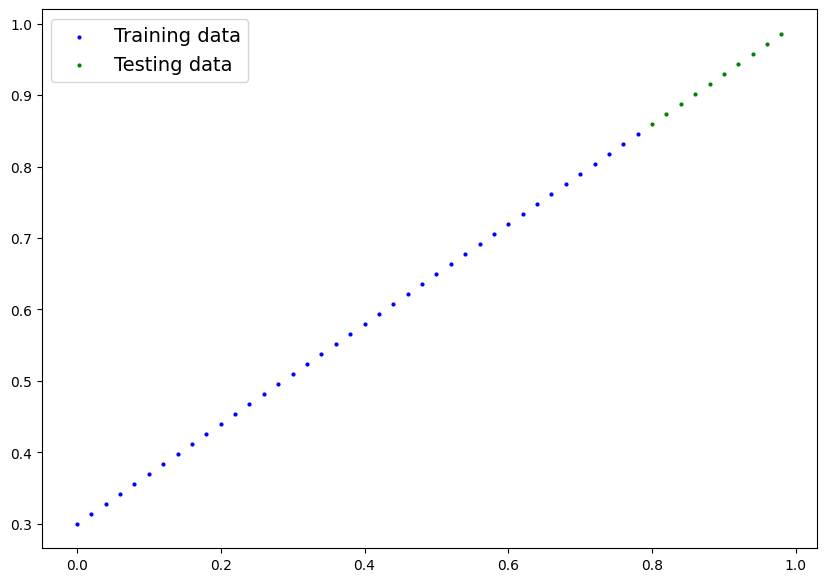

In [6]:
plot_predictions()

# 2. Build a model

In [7]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # requires_gradient let you update valus via gradient descent
        self.weight = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias  # regression formula

### Pytorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graphs)
* `torch.nn.Parameter` - what parameters should our model try and learn
* `torch.nn.Module` - the base class for all nural network modules, if you subclass it, you shoul overwrite `forward()` method
* `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent

[PyTorch cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html)

### Checking the content of our pytorch model

In [8]:
# Create a random seed, since we are using random values
torch.manual_seed(42)

# create an instancel of the model
model_0 = LinearRegressionModel()

# check out the paramethers
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [9]:
# list named parameter
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [10]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_model()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.


In [11]:
# Make predictions with model
with torch.inference_mode():
    # inference model disable gradient descent tracking
    # its faster
    y_preds = model_0(X_test)

# can do smt similar with no_grad(), but inference_mode() is preferred
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

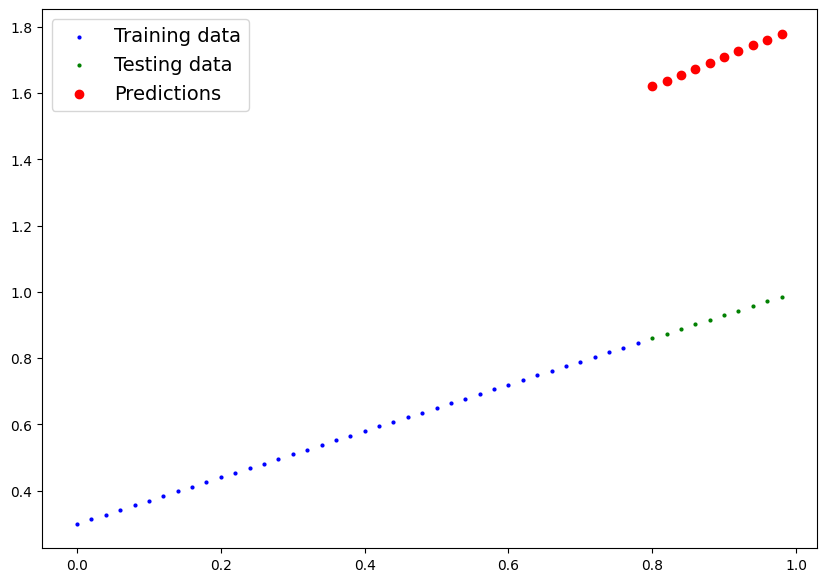

In [12]:
plot_predictions(predictions=y_preds)

## Train model

The whole idea of training of a model is to move from some unknown parameters (these may be random) to some known parameters.

One way to measure how poor or how wrong is to use a loss function.

Note: Loss function may also be called cost function or criterion in different areas. For our case, we`re going to refer to it as a loss function.

Things we need to train:

* **Los function**: a function to measure how wrong your model's predictions are to the idea outputs, lower is better.
https://pytorch.org/docs/stable/nn.html#loss-functions
* **Opmitizer**: takes into account the loss of a model and adjust the model's parameters (e.g. weight and bias) to improve the loss function. https://pytorch.org/docs/stable/optim.html#module-torch.optim

In pytorch, we need:
* a trining loop
* a testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [14]:
# check out our model's parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descend)
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01) # learning rate

In [16]:
loss_fn

L1Loss()

### Building a training loop (and training loop) in PyTorch

A couple thins we need in a training loop:
0. Loop through the data
1. Forward pass (this involces data moving through our model's `forward()` - also known as forward propagation)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward (**backpropagation**) - move backewards through the network to calculate the gradients of the parameters of our model with respect to the loss
5. Optimizer step (**gradient descent**) - use the optimizer to adjust our model's parameters to try and improve the loss.

In [17]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter)
epochs = 100
# Tracking values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in pytorch sets all parameter that requires gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f"loss: {loss}")

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop... so we have zero them above them in step 3 for the next iteration of the loop

    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

        print(model_0.state_dict())

Epoch: 0 | Loss: 0.6860889196395874 | Test loss: 0.7637526988983154
OrderedDict([('weight', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | Loss: 0.5708791017532349 | Test loss: 0.6290428042411804
OrderedDict([('weight', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | Loss: 0.45566922426223755 | Test loss: 0.4943329691886902
OrderedDict([('weight', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | Loss: 0.34045934677124023 | Test loss: 0.35962313413619995
OrderedDict([('weight', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch: 40 | Loss: 0.2252494841814041 | Test loss: 0.2249133139848709
OrderedDict([('weight', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch: 50 | Loss: 0.1100396141409874 | Test loss: 0.09020347893238068
OrderedDict([('weight', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch: 60 | Loss: 0.009724985808134079 | Test loss: 0.020998019725084305
OrderedDict([('weight', tensor([0.6539])), ('bias', tensor([0.3200]))])
Epoch:

In [18]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [19]:
weight, bias

(0.7, 0.3)

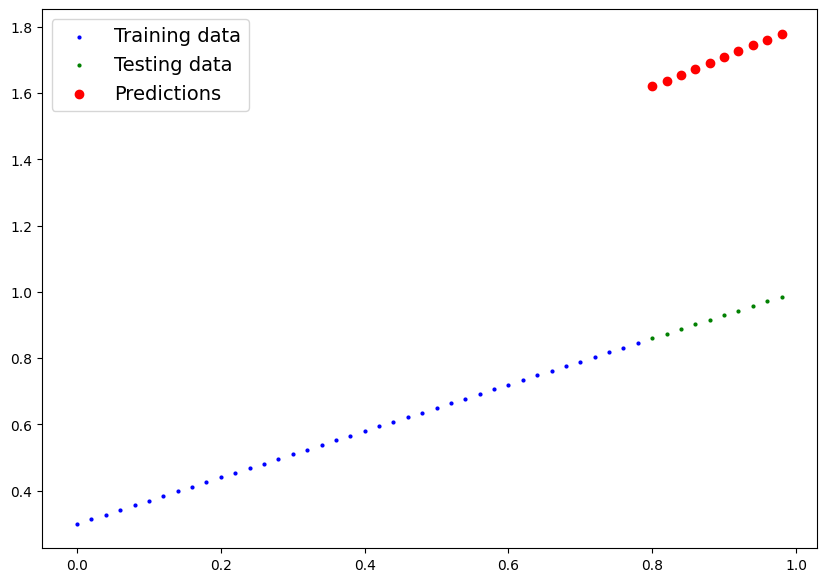

In [20]:
plot_predictions(predictions=y_preds)

In [21]:
with torch.inference_mode():
    y_pred = model_0(X_test)

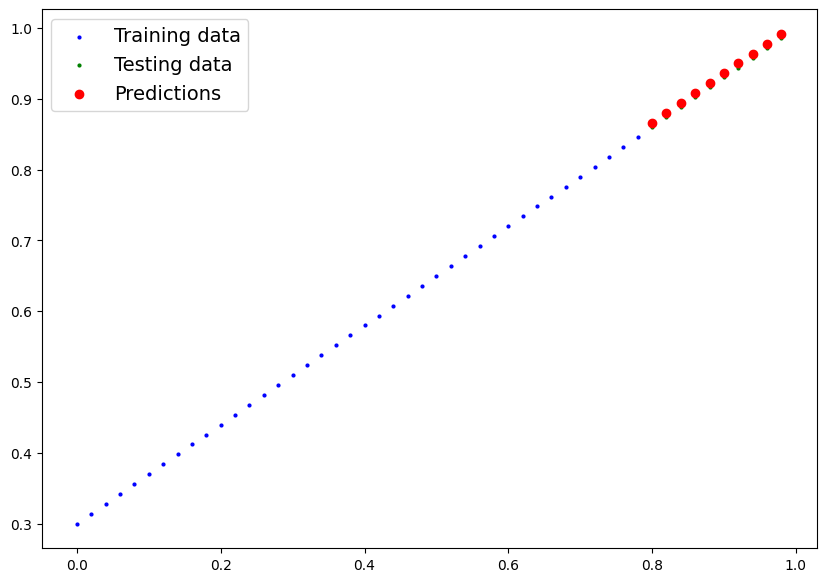

In [22]:
plot_predictions(predictions=y_pred)

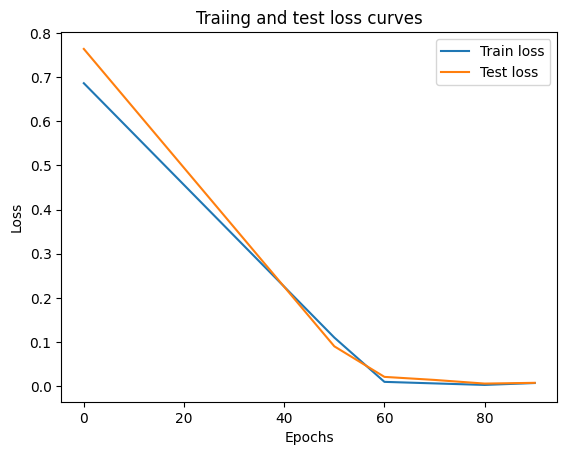

In [29]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values)), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Traiing and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()